# GSoC2020 Trigger Task
By Rui Xi

## Data Exploration and Cleaning

### Explore Dataset and Standardization

In [0]:
import numpy as np
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = np.load('/content/drive/My Drive/histos_tba.20.npz')
data.files

['variables', 'parameters']

In [4]:
variables = data['variables']
print(variables.shape)
parameters = data['parameters']
print(parameters.shape)

(3272341, 87)
(3272341, 3)


In [0]:
# since we only care about the q/pt, drop phi and eta angle
parameters = parameters[:,1]
# set all NaN to 0
variables = np.nan_to_num(variables)
parameters = np.nan_to_num(parameters)

In [6]:
print(variables[1,:20])
print(parameters[1:20])

[2865.    0. 2622. 2608.    0.    0.    0. 2604. 2600.    0. 2661. 2937.
    7.    0.    6.    6.    0.    0.    0.    8.]
[ 3.0257308   3.1199055  -3.0759358  -0.47497758 -0.16713923  2.57163
  2.725565    2.4318233  -1.3433052  -3.1344328  -1.6402272  -0.43685243
 -2.8282223  -0.8729258   2.2309427  -3.1097283   0.7452868   2.0010202
  0.9158598 ]


In [7]:
print(variables[:20,3])
variables = preprocessing.scale(variables)
print(variables[:20,3])

[3568. 2608. 1440. 3328. 4648. 4024.    0. 3808. 3976. 1872. 4098. 1532.
 3336. 2168.    0.    0.    0.    0. 2818.    0.]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[ 0.8344433   0.1998117  -0.5723234   0.67578536  1.5484037   1.1358933
 -1.5242707   0.9931012   1.1041617  -0.28673917  1.1848129  -0.51150453
  0.681074   -0.09106109 -1.5242707  -1.5242707  -1.5242707  -1.5242707
  0.33863735 -1.5242707 ]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [8]:
# since q = +-1, get 1/pt from q/pt by abs(q/pt)
parameters = np.absolute(parameters)
print(parameters[1:20])

[3.0257308  3.1199055  3.0759358  0.47497758 0.16713923 2.57163
 2.725565   2.4318233  1.3433052  3.1344328  1.6402272  0.43685243
 2.8282223  0.8729258  2.2309427  3.1097283  0.7452868  2.0010202
 0.9158598 ]


In [9]:
# get pt from 1/pt
pt = 1.0 / parameters
print(parameters[1:20])

[3.0257308  3.1199055  3.0759358  0.47497758 0.16713923 2.57163
 2.725565   2.4318233  1.3433052  3.1344328  1.6402272  0.43685243
 2.8282223  0.8729258  2.2309427  3.1097283  0.7452868  2.0010202
 0.9158598 ]


In [10]:
# convert pt to class
pt_class = np.zeros((3272341, 1))
pt_class[np.logical_and(0 <= pt, pt < 10)] = 0
pt_class[np.logical_and(10 <= pt, pt < 30)] = 1
pt_class[np.logical_and(30 <= pt, pt < 100)] = 2
pt_class[100 <= pt] = 3
print(pt_class[1:20])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [11]:
variables = np.concatenate((variables, pt_class), axis=1)
print(variables.shape)

(3272341, 88)


In [12]:
#find dataset very unbalanced, tyy upsampling
print(np.count_nonzero(pt_class==0), 
      np.count_nonzero(pt_class==1), 
      np.count_nonzero(pt_class==2), 
      np.count_nonzero(pt_class==3))
print(np.count_nonzero(pt_class==0) / len(variables), 
      np.count_nonzero(pt_class==1) / len(variables), 
      np.count_nonzero(pt_class==2) / len(variables), 
      np.count_nonzero(pt_class==3) / len(variables))

3168598 68912 24373 10458
0.9682970081663249 0.021058929983152733 0.007448184648238066 0.0031958772022842364


### Upsampling Biased Dataset
Downsampling a bit as well to save RAM

In [13]:
class_zero = variables[(pt_class == 0).ravel(),:]
class_zero = class_zero[:1000000, :]

class_one = variables[(pt_class == 1).ravel(),:]
class_two = variables[(pt_class == 2).ravel(),:]
class_three = variables[(pt_class == 3).ravel(),:]

print(class_zero.shape, class_one.shape, class_two.shape, class_three.shape)

class_one = np.tile(class_one, ( int(class_zero.shape[0] / class_one.shape[0]), 1))
class_two = np.tile(class_two, ( int(class_zero.shape[0] / class_two.shape[0]), 1))
class_three = np.tile(class_three, ( int(class_zero.shape[0] / class_three.shape[0]), 1))

print(class_zero.shape, class_one.shape, class_two.shape, class_three.shape)



(1000000, 88) (68912, 88) (24373, 88) (10458, 88)
(1000000, 88) (964768, 88) (999293, 88) (993510, 88)


In [14]:
new_variables = np.concatenate((class_zero, class_one, class_two, class_three), axis=0)
print(new_variables.shape)

(3957571, 88)


In [15]:
print(new_variables[1,:])

[ 5.17105103e-01 -5.60436964e-01  1.13634519e-01  1.99811697e-01
 -1.37428224e+00 -4.39748555e-01 -4.14589882e-01  1.48011073e-01
  3.05932045e-01 -8.44235420e-01  5.73869765e-01  1.41708386e+00
 -6.76860273e-01 -5.96212268e-01 -9.76999223e-01 -8.77977192e-01
 -1.08148444e+00 -4.69723225e-01 -4.40024763e-01 -8.34744394e-01
 -6.90945923e-01 -8.57729733e-01 -4.58291233e-01  4.25719649e-01
 -1.31223953e+00  1.95743260e-03 -7.29299756e-03 -1.87553349e-03
 -3.86041566e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.08361675e-04  5.95898135e-04 -2.47023511e+00
  1.05663054e-01  8.87512267e-02  1.40661880e-01  1.40437290e-01
  1.13052219e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.52050591e+00 -6.06406093e-01 -8.96736979e-02 -8.51297379e-02
 -1.41177535e+00 -4.78252023e-01 -4.44178402e-01 -2.81151235e-01
 -1.56040117e-01 -9.35597599e-01  8.02693248e-01  1.40748906e+00
 -7.34001040e-01 -3.81279

### Data Loader

In [0]:
np.random.shuffle(new_variables)

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
class MuonDataset(Dataset):
    def __init__(self, feature, label, transform=None):
        self.feature = feature
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        feature = torch.tensor(self.feature[idx], dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.long)
        if self.transform is not None:
            self.feature = self.transform(self.feature)
        sample = {'feature': feature, 'label': label}
        return sample

In [0]:
def data_loader(train_feature, train_lable, test_feature, test_label):
    # define a trainset
    trainset = MuonDataset(train_feature, train_lable)
    print(trainset)
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    # define a testset
    testset = MuonDataset(test_feature, test_label)
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

### Train Visualization

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

## Task 1: Muon Momentum Interfaces

### Fully Connected Net

In [0]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [0]:
class FCNetwork(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        '''
        Args:
        n_feature(int): size of input tensor
        n_hidden(int): size of hidden layer
        n_output(int): size of output tensor
        '''
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.bn2 = nn.BatchNorm1d(n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.bn3 = nn.BatchNorm1d(n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        '''
        x(tensor): inputs of the network
        '''
        out = F.relu(self.fc1(x))
        out = self.bn1(out)
        out = F.relu(self.fc2(out))
        out = self.bn2(out)
        out = F.relu(self.fc3(out))
        out = self.bn3(out)
        out = self.predict(out)
        return F.softmax(out)

In [0]:
def train(epoch, model, lossFunction, optimizer, device, trainloader):
    """train model using loss_fn and optimizer. When this function is called, model trains for one epoch.
    Args:
        train_loader: train data
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
        optimizer: optimize the loss function
        get_grad: True, False
    output:
        total_loss: loss
        average_grad2: average grad for hidden 2 in this epoch
        average_grad3: average grad for hidden 3 in this epoch
    """
    print('\nEpoch: %d' % epoch)
    model.train()     # enter train mode
    train_loss = 0    # accumulate every batch loss in a epoch
    correct = 0       # count when model' prediction is correct i train set
    total = 0         # total number of prediction in train set
    for batch_idx, data in enumerate(trainloader):
        inputs, targets = data['feature'], data['label']
        inputs, targets = inputs.to(device), targets.to(device) # load data to gpu device
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()            # clear gradients of all optimized torch.Tensors'
        outputs = model(inputs)          # forward propagation return the value of softmax function
        #print('target', targets)
        targets = targets.squeeze_()
        loss = lossFunction(outputs, targets) #compute loss
        loss.backward()                  # compute gradient of loss over parameters 
        optimizer.step()                 # update parameters with gradient descent 

        train_loss += loss.item()        # accumulate every batch loss in a epoch
        _, predicted = outputs.max(1)    # make prediction according to the outputs
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        
    print( 'Train loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_loss = train_loss/(batch_idx+1)
    
    return train_loss
    
    
def test(model, lossFunction, optimizer, device, testloader):
    """
    test model's prediction performance on loader.  
    When thid function is called, model is evaluated.
    Args:
        loader: data for evaluation
        model: prediction model
        loss_fn: loss function to judge the distance between target and outputs
    output:
        total_loss
        accuracy
    """
    model.eval() #enter test mode
    test_loss = 0 # accumulate every batch loss in a epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            inputs, targets = data['feature'], data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze_()
            loss = lossFunction(outputs, targets) #compute loss

            test_loss += loss.item() # accumulate every batch loss in a epoch
            _, predicted = outputs.max(1) # make prediction according to the outputs
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # count how many predictions is correct
        # print loss and acc
        print('Test Loss: %.3f  | Test Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        test_loss = test_loss/(batch_idx+1)
        
    return test_loss

In [0]:
def run(model, num_epochs, optimizer, trainloader, testloader, device='cpu', lossFunction=nn.CrossEntropyLoss(), lr=0.01):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        torch.backends.cudnn.benchmark=True

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        train_loss_list.append(train(epoch, model, lossFunction, optimizer, device, trainloader))
        test_loss_list.append(test(model, lossFunction, optimizer, device, testloader))

    return train_loss_list, test_loss_list

In [0]:
# traninset(size=3,000,000) and testset(size=957571)
train_feature = new_variables[0:3000000, :-1]
train_lable = new_variables[:3000000, -1]
test_feature = new_variables[3000000:, :-1]
test_label = new_variables[3000000:, -1]

print(train_feature.shape, train_lable.shape, test_feature.shape, test_label.shape)

(3000000, 87) (3000000,) (957571, 87) (957571,)


In [0]:
num_epochs = 10
batch_size = 256
lr = 0.1
trainloader, testloader = data_loader(train_feature, train_lable, test_feature, test_label)
device='cpu'
lossFunction = nn.CrossEntropyLoss()
model = FCNetwork(87, 100, 4)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

print(model)

FCNetwork(
  (fc1): Linear(in_features=87, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predict): Linear(in_features=100, out_features=4, bias=True)
)



Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 1.204 | Train Acc: 49.758% (1492726/3000000)
Test Loss: 1.226  | Test Acc: 46.962% (449698/957571)

Epoch: 1
Train loss: 1.199 | Train Acc: 50.259% (1507781/3000000)
Test Loss: 1.214  | Test Acc: 48.091% (460509/957571)

Epoch: 2
Train loss: 1.200 | Train Acc: 50.100% (1502986/3000000)
Test Loss: 1.195  | Test Acc: 50.386% (482477/957571)

Epoch: 3
Train loss: 1.200 | Train Acc: 50.126% (1503767/3000000)
Test Loss: 1.213  | Test Acc: 48.752% (466832/957571)

Epoch: 4
Train loss: 1.200 | Train Acc: 50.163% (1504899/3000000)
Test Loss: 1.200  | Test Acc: 50.314% (481796/957571)

Epoch: 5
Train loss: 1.200 | Train Acc: 50.106% (1503168/3000000)
Test Loss: 1.202  | Test Acc: 49.665% (475580/957571)

Epoch: 6
Train loss: 1.200 | Train Acc: 50.042% (1501254/3000000)
Test Loss: 1.199  | Test Acc: 50.034% (479109/957571)

Epoch: 7
Train loss: 1.201 | Train Acc: 50.011% (1500345/3000000)
Test Loss: 1.199  | Test Acc: 50.339% (482036/957571)

Epoch: 8
Train loss: 1.201 | Train Acc: 4

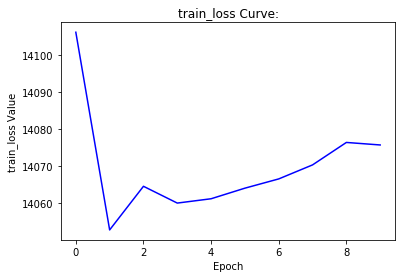

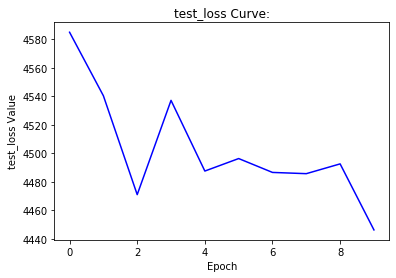

In [0]:
train_loss_list, test_loss_list = run(model, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')

In [0]:
train_feature = new_variables[0:1000, :-1]
train_lable = new_variables[:1000, -1]
test_feature = new_variables[1000:1200, :-1]
test_label = new_variables[1000:1200, -1]

print(train_feature.shape, train_lable.shape, test_feature.shape, test_label.shape)
trainloader, testloader = data_loader(train_feature, train_lable, test_feature, test_label)

num_epochs = 40
batch_size = 256
lr = 0.1

device='cpu'
lossFunction = nn.CrossEntropyLoss()
model = FCNetwork(87, 100, 4)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
print(model)

(1000, 87) (1000,) (200, 87) (200,)
FCNetwork(
  (fc1): Linear(in_features=87, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predict): Linear(in_features=100, out_features=4, bias=True)
)



Epoch: 0
Train loss: 1.393 | Train Acc: 27.200% (272/1000)
Test Loss: 1.387  | Test Acc: 22.000% (44/200)

Epoch: 1
Train loss: 1.357 | Train Acc: 38.700% (387/1000)
Test Loss: 1.386  | Test Acc: 23.500% (47/200)

Epoch: 2
Train loss: 1.311 | Train Acc: 45.400% (454/1000)
Test Loss: 1.383  | Test Acc: 28.000% (56/200)

Epoch: 3
Train loss: 1.264 | Train Acc: 51.600% (516/1000)
Test Loss: 1.378  | Test Acc: 32.500% (65/200)

Epoch: 4
Train loss: 1.213 | Train Acc: 58.100% (581/1000)
Test Loss: 1.374  | Test Acc: 30.500% (61/200)

Epoch: 5
Train loss: 1.160 | Train Acc: 61.800% (618/1000)
Test Loss: 1.367  | Test Acc: 31.000% (62/200)

Epoch: 6
Train loss: 1.104 | Train Acc: 67.100% (671/1000)
Test Loss: 1.375  | Test Acc: 30.500% (61/200)

Epoch: 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 1.067 | Train Acc: 70.900% (709/1000)
Test Loss: 1.375  | Test Acc: 33.500% (67/200)

Epoch: 8
Train loss: 1.033 | Train Acc: 74.300% (743/1000)
Test Loss: 1.372  | Test Acc: 35.000% (70/200)

Epoch: 9
Train loss: 1.026 | Train Acc: 74.200% (742/1000)
Test Loss: 1.422  | Test Acc: 27.000% (54/200)

Epoch: 10
Train loss: 1.015 | Train Acc: 74.600% (746/1000)
Test Loss: 1.395  | Test Acc: 31.500% (63/200)

Epoch: 11
Train loss: 0.996 | Train Acc: 76.100% (761/1000)
Test Loss: 1.398  | Test Acc: 32.000% (64/200)

Epoch: 12
Train loss: 0.983 | Train Acc: 77.900% (779/1000)
Test Loss: 1.379  | Test Acc: 34.500% (69/200)

Epoch: 13
Train loss: 0.970 | Train Acc: 78.700% (787/1000)
Test Loss: 1.387  | Test Acc: 32.000% (64/200)

Epoch: 14
Train loss: 0.972 | Train Acc: 78.900% (789/1000)
Test Loss: 1.387  | Test Acc: 28.500% (57/200)

Epoch: 15
Train loss: 0.953 | Train Acc: 81.100% (811/1000)
Test Loss: 1.362  | Test Acc: 35.500% (71/200)

Epoch: 16
Train loss: 0.955 | Train Acc:

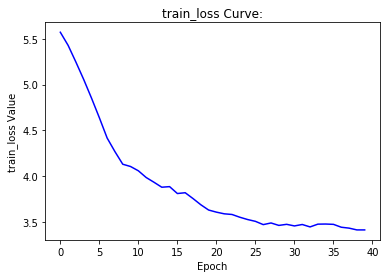

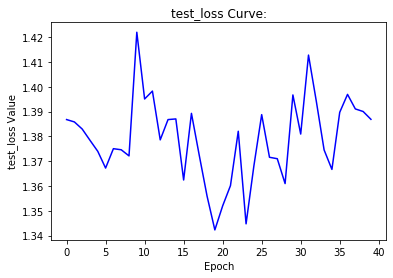

In [0]:
train_loss_list, test_loss_list = run(model, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')

In [0]:
print(train_loss_list)

[5.5706236362457275, 5.427241921424866, 5.244492411613464, 5.054307341575623, 4.851099491119385, 4.638060092926025, 4.416297912597656, 4.267646551132202, 4.130563497543335, 4.1056495904922485, 4.058847486972809, 3.985668659210205, 3.933863580226898, 3.879664719104767, 3.886131763458252, 3.810802698135376, 3.8195087909698486, 3.756142258644104, 3.688505709171295, 3.630777657032013, 3.607713520526886, 3.5894875526428223, 3.582208216190338, 3.5521891713142395, 3.527062237262726, 3.507259428501129, 3.4716585874557495, 3.489542067050934, 3.4629783630371094, 3.4747731685638428, 3.457263469696045, 3.472905218601227, 3.446544587612152, 3.476712167263031, 3.477959096431732, 3.4744812846183777, 3.443164885044098, 3.433222472667694, 3.4138017296791077, 3.413780927658081]


### CNN (ResNet)


In [0]:
a = np.array(range(87))
b = np.resize(a, 100)
c = np.pad(np.reshape(b, (10,10)), (11, 11), 'reflect')
print(c.shape)


(32, 32)


In [0]:
# construct Variable to a 10*10 2d array
class Muon2dDataset(Dataset):
    def __init__(self, feature, label, transform=None):
        self.feature = feature
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        raw_feature = np.resize(self.feature[idx], 10*10)
        raw_feature = np.pad(np.reshape(raw_feature, (10,10)), (11, 11), 'reflect')
        feature = torch.tensor(np.reshape(raw_feature, (1,32,32)), dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.long)
        if self.transform is not None:
            self.feature = self.transform(self.feature)
        sample = {'feature': feature, 'label': label}
        return sample

In [0]:
# Residual block (two 3*3 conv layers version)
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self, x):
        """
        Defines the computation performed at every call.
        x: N * C * H * W
        """
        residual = x
        # if the size of input x changes, using downsample to change the size of residual
        if self.downsample:
            residual = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self, block=ResidualBlock, layers=[2, 2, 2], num_classes=10):
        """
        block: ResidualBlock
        layers: a list with 3 positive num.
        """
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        # layer1: image size 32
        self.layer1 = self.make_layer(block, 16, num_blocks=layers[0])
        # layer2: image size 32 -> 16
        self.layer2 = self.make_layer(block, 32, num_blocks=layers[1], stride=2)
        # layer1: image size 16 -> 8
        self.layer3 = self.make_layer(block, 64, num_blocks=layers[2], stride=2)
        # global avg pool: image size 8 -> 1
        self.avg_pool = nn.AvgPool2d(8)
    
        self.fc = nn.Linear(64, num_classes)

                
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        """
        make a layer with num_blocks blocks.
        """
        
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            # use Conv2d with stride to downsample
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # first block with downsample
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        # add num_blocks - 1 blocks
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        # return a layer containing layers
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        # view: here change output size from 4 dimensions to 2 dimensions
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
def data_loader_2d(train_feature, train_lable, test_feature, test_label):
    # define a trainset
    trainset = Muon2dDataset(train_feature, train_lable)
    print(trainset)
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    # define a testset
    testset = Muon2dDataset(test_feature, test_label)
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

In [0]:
resnet = ResNet(ResidualBlock, [2, 2, 2], 4)
print(resnet)

# Hyper-parameters
batch_size = 256
num_epochs = 10
lossFunction = nn.CrossEntropyLoss()
lr = 0.001
device = 'cpu'
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [0]:
train_feature = new_variables[0:1000, :-1]
train_lable = new_variables[:1000, -1]
test_feature = new_variables[1000:1200, :-1]
test_label = new_variables[1000:1200, -1]

print(train_feature.shape, train_lable.shape, test_feature.shape, test_label.shape)
trainloader, testloader = data_loader_2d(train_feature, train_lable, test_feature, test_label)

(1000, 87) (1000,) (200, 87) (200,)



Epoch: 0
Train loss: 1.589 | Train Acc: 24.600% (246/1000)
Test Loss: 1.392  | Test Acc: 22.500% (45/200)

Epoch: 1
Train loss: 1.396 | Train Acc: 32.800% (328/1000)
Test Loss: 1.384  | Test Acc: 27.000% (54/200)

Epoch: 2
Train loss: 1.348 | Train Acc: 32.700% (327/1000)
Test Loss: 1.383  | Test Acc: 24.500% (49/200)

Epoch: 3
Train loss: 1.301 | Train Acc: 38.100% (381/1000)
Test Loss: 1.392  | Test Acc: 24.500% (49/200)

Epoch: 4
Train loss: 1.236 | Train Acc: 43.300% (433/1000)
Test Loss: 1.396  | Test Acc: 24.000% (48/200)

Epoch: 5
Train loss: 1.129 | Train Acc: 51.400% (514/1000)
Test Loss: 1.498  | Test Acc: 23.000% (46/200)

Epoch: 6
Train loss: 0.973 | Train Acc: 63.300% (633/1000)
Test Loss: 1.867  | Test Acc: 25.000% (50/200)

Epoch: 7
Train loss: 0.883 | Train Acc: 65.300% (653/1000)
Test Loss: 2.248  | Test Acc: 25.500% (51/200)

Epoch: 8
Train loss: 0.703 | Train Acc: 75.800% (758/1000)
Test Loss: 2.142  | Test Acc: 28.000% (56/200)

Epoch: 9
Train loss: 0.607 | Train A

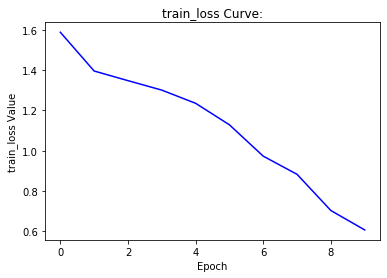

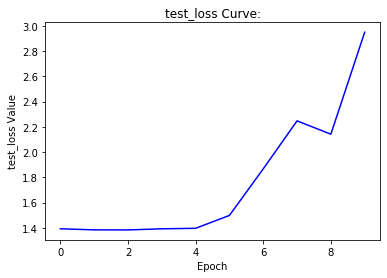

In [0]:
train_loss_list, test_loss_list = run(resnet, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')

In [0]:
train_feature = new_variables[0:3000000, :-1]
train_lable = new_variables[:3000000, -1]
test_feature = new_variables[3000000:, :-1]
test_label = new_variables[3000000:, -1]

print(train_feature.shape, train_lable.shape, test_feature.shape, test_label.shape)
trainloader, testloader = data_loader_2d(train_feature, train_lable, test_feature, test_label)

(3000000, 87) (3000000,) (957571, 87) (957571,)


In [0]:
resnet = ResNet(ResidualBlock, [2, 2, 2], 4)
print(resnet)

# Hyper-parameters
batch_size = 256
num_epochs = 10
lossFunction = nn.CrossEntropyLoss()
lr = 0.001
device = 'cpu'
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=


Epoch: 0
Train loss: 0.849 | Train Acc: 61.185% (1835539/3000000)
Test Loss: 0.712  | Test Acc: 69.205% (662687/957571)

Epoch: 1
Train loss: 0.635 | Train Acc: 73.091% (2192728/3000000)
Test Loss: 0.576  | Test Acc: 76.090% (728612/957571)

Epoch: 2
Train loss: 0.544 | Train Acc: 77.555% (2326648/3000000)
Test Loss: 0.514  | Test Acc: 79.132% (757749/957571)

Epoch: 3
Test Loss: 0.464  | Test Acc: 81.427% (779726/957571)

Epoch: 4
Train loss: 0.453 | Train Acc: 81.863% (2455884/3000000)
Test Loss: 0.436  | Test Acc: 82.735% (792249/957571)

Epoch: 5
Train loss: 0.424 | Train Acc: 83.212% (2496362/3000000)
Test Loss: 0.418  | Test Acc: 83.636% (800878/957571)

Epoch: 6
Train loss: 0.401 | Train Acc: 84.252% (2527567/3000000)
Test Loss: 0.396  | Test Acc: 84.689% (810962/957571)

Epoch: 7
Train loss: 0.382 | Train Acc: 85.135% (2554045/3000000)
Test Loss: 0.364  | Test Acc: 86.159% (825037/957571)

Epoch: 8
Train loss: 0.366 | Train Acc: 85.840% (2575190/3000000)
Test Loss: 0.361  | Te

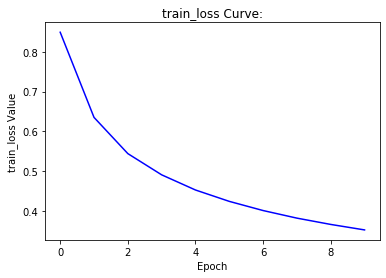

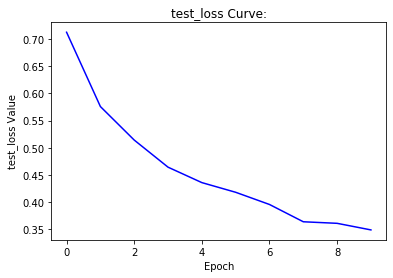

In [0]:
train_loss_list, test_loss_list = run(resnet, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')

### Regression


In [0]:
class MuonRegressionDataset(Dataset):
    def __init__(self, feature, label, transform=None):
        self.feature = feature
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        feature = torch.tensor(self.feature[idx], dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.float32)
        if self.transform is not None:
            self.feature = self.transform(self.feature)
        sample = {'feature': feature, 'label': label}
        return sample

In [0]:
def data_loader_regression(train_feature, train_lable, test_feature, test_label):
    # define a trainset
    trainset = MuonRegressionDataset(train_feature, train_lable)
    print(trainset)
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    # define a testset
    testset = MuonRegressionDataset(test_feature, test_label)
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

In [0]:
train_feature = variables[0:1000, :-1]
train_lable = parameters[:1000]
test_feature = variables[1000:1200, :-1]
test_label = parameters[1000:1200]

In [0]:
def train(epoch, model, lossFunction, optimizer, device, trainloader):
    print('\nEpoch: %d' % epoch)
    model.train()     # enter train mode
    train_loss = 0    # accumulate every batch loss in a epoch
    total = 0         # total number of prediction in train set
    for batch_idx, data in enumerate(trainloader):
        inputs, targets = data['feature'], data['label']
        inputs, targets = inputs.to(device), targets.to(device) # load data to gpu device
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()            # clear gradients of all optimized torch.Tensors'
        outputs = model(inputs)          # forward propagation return the value of softmax function
        targets = targets.squeeze_()
        loss = lossFunction(outputs, targets) #compute loss
        loss.backward()                  # compute gradient of loss over parameters 
        optimizer.step()                 # update parameters with gradient descent 

        train_loss += loss.item()        # accumulate every batch loss in a epoch
        total += targets.size(0)
        
    print( 'Train loss: %.3f' % (train_loss/(batch_idx+1)))
    train_loss = train_loss/(batch_idx+1)
    
    return train_loss
    
    
def test(model, lossFunction, optimizer, device, testloader):
    model.eval() #enter test mode
    test_loss = 0 # accumulate every batch loss in a epoch
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            inputs, targets = data['feature'], data['label']
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze_()
            loss = lossFunction(outputs, targets) #compute loss

            test_loss += loss.item() # accumulate every batch loss in a epoch

        # print loss and acc
        print('Test Loss: %.3f' % (test_loss/(batch_idx+1)))
        test_loss = test_loss/(batch_idx+1)
        
    return test_loss

In [0]:
def run(model, num_epochs, optimizer, trainloader, testloader, device='cpu', lossFunction=nn.CrossEntropyLoss(), lr=0.01):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model)
        torch.backends.cudnn.benchmark=True

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        train_loss_list.append(train(epoch, model, lossFunction, optimizer, device, trainloader))
        test_loss_list.append(test(model, lossFunction, optimizer, device, testloader))

    return train_loss_list, test_loss_list

In [0]:
model = nn.Linear(87, 1)

trainloader, testloader = data_loader_regression(train_feature, train_lable, test_feature, test_label)

# Hyper-parameters
num_epochs = 10
batch_size = 256
lr = 0.001
device = 'cpu'
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)


Epoch: 0
Train loss: 3.731
Test Loss: 4.097

Epoch: 1
Train loss: 3.729
Test Loss: 4.097

Epoch: 2
Train loss: 3.736
Test Loss: 4.097

Epoch: 3
Train loss: 3.737
Test Loss: 4.097

Epoch: 4


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([232])) that is different to the input size (torch.Size([232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Train loss: 3.737
Test Loss: 4.097

Epoch: 5
Train loss: 3.738
Test Loss: 4.097

Epoch: 6
Train loss: 3.747
Test Loss: 4.097

Epoch: 7
Train loss: 3.732
Test Loss: 4.097

Epoch: 8
Train loss: 3.736
Test Loss: 4.097

Epoch: 9
Train loss: 3.749
Test Loss: 4.097


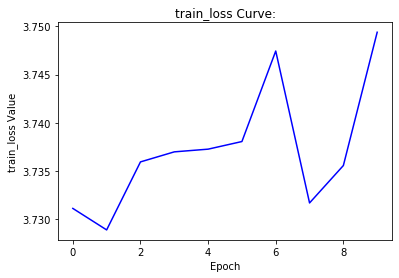

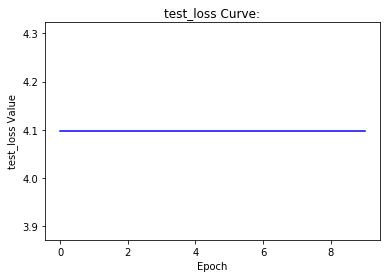

In [0]:
train_loss_list, test_loss_list = run(model, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')

## Task2: Image-based CNN


In [0]:
# construct Variable to a 10*10 2d array
class Muon2dDataset(Dataset):
    def __init__(self, feature, label, transform=None):
        self.feature = feature
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        raw_feature = np.resize(self.feature[idx], 10*10)
        raw_feature = np.pad(np.reshape(raw_feature, (10,10)), (11, 11), 'reflect')
        feature = torch.tensor(np.reshape(raw_feature, (1,32,32)), dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.long)
        if self.transform is not None:
            self.feature = self.transform(self.feature)
        sample = {'feature': feature, 'label': label}
        return sample

In [0]:
def data_loader_2d(train_feature, train_lable, test_feature, test_label):
    # define a trainset
    trainset = Muon2dDataset(train_feature, train_lable)
    print(trainset)
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    # define a testset
    testset = Muon2dDataset(test_feature, test_label)
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

In [31]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 255))
print(min_max_scaler.fit(new_variables[:,:-1]))
new_variables_minmax = min_max_scaler.transform(new_variables[:,:-1])
new_variables_minmax = np.concatenate((new_variables_minmax, np.reshape(new_variables[:,-1],(len(new_variables[:,-1]),1))), axis=1)
print(new_variables_minmax)

MinMaxScaler(copy=True, feature_range=(0, 255))
[[ 98.78885058   0.          96.6673302  ...   0.          94.56953907
    0.        ]
 [  0.         144.42432673 139.54480355 ... 255.         138.47682202
    2.        ]
 [ 59.00741924   0.          68.87161072 ...   0.          62.48345234
    1.        ]
 ...
 [  0.         187.19951945 185.71658335 ... 255.         185.76158814
    3.        ]
 [  0.         149.68737683 145.77310664 ... 255.         145.23178836
    2.        ]
 [152.52957958   0.         140.41985425 ...  51.00000343 141.85430519
    1.        ]]


In [32]:
train_feature = new_variables_minmax[0:3000000, :-1]
train_lable = new_variables_minmax[:3000000, -1]
test_feature = new_variables_minmax[3000000:, :-1]
test_label = new_variables_minmax[3000000:, -1]

print(train_feature.shape, train_lable.shape, test_feature.shape, test_label.shape)

(3000000, 87) (3000000,) (957571, 87) (957571,)


torch.Size([256, 1, 32, 32])


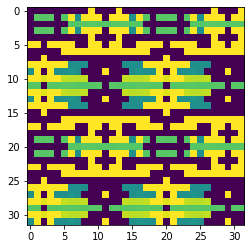

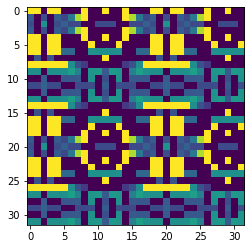

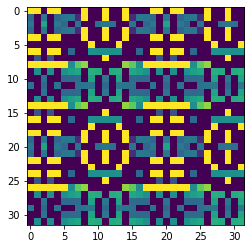

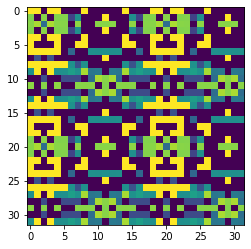

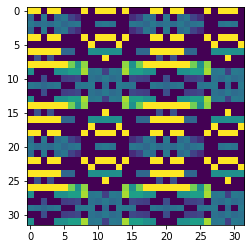

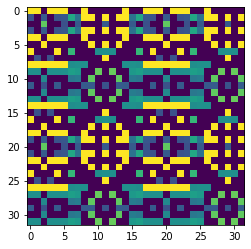

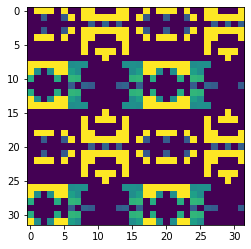

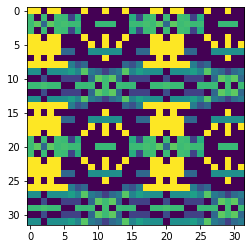

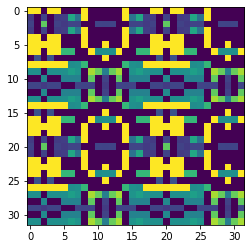

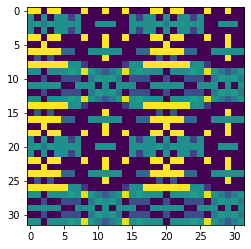

In [33]:
batch_size=256
trainloader, testloader = data_loader_2d(train_feature, train_lable, test_feature, test_label)
for data in trainloader:
  print(data['feature'].shape)
  for i in range(10):
    plt.figure()
    plt.imshow(data['feature'][i][0])

  break


In [34]:
resnet = ResNet(ResidualBlock, [2, 2, 2], 4)
print(resnet)

# Hyper-parameters
batch_size = 256
num_epochs = 10
lossFunction = nn.CrossEntropyLoss()
lr = 0.001
device = 'cpu'
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [37]:
train_loss_list, test_loss_list = run(resnet, num_epochs, optimizer, trainloader, testloader, device, lossFunction, lr)
show_curve(train_loss_list, 'train_loss')
show_curve(test_loss_list, 'test_loss')


Epoch: 0
Train loss: 0.917 | Train Acc: 56.830% (1704886/3000000)
Test Loss: 0.795  | Test Acc: 64.117% (613966/957571)

Epoch: 1
Train loss: 0.718 | Train Acc: 68.462% (2053859/3000000)
Test Loss: 0.670  | Test Acc: 70.886% (678782/957571)

Epoch: 2


KeyboardInterrupt: ignored